In [1]:
!pip install marisa-trie

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from torchtext.legacy import data

from torchtext import vocab

from marisa_trie import Trie

import re

from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

import string

from typing import *

# Load data

In [3]:
FOLDER = "/content/drive/MyDrive/CompTech2022/Classes/"

In [4]:
dfByAlph = dict()

for char in list(string.ascii_lowercase):
    dfByAlph[char] = pd.read_csv(FOLDER + f"{char.upper()}.csv", header=None).iloc[:5000]

In [5]:
dfByAlph['y'].head()

,0,1
0,Yylex,28
1,YambaApplication,27
2,Year,26
3,Yytoken,21
4,YahooParserTest,16


# Split by subwords

In [6]:
def split_case(x, lower=False):
    res = re.findall('[A-Z][^A-Z]*', x)
    if lower:
        res = [sw.lower() for sw in res]
    return res

In [7]:
#def mergeAndUp(x: List) -> str:

In [7]:
dataByAlph = dict()
# noSplitDataByAlph = dict()
for char in tqdm(list(string.ascii_lowercase)):
    dataByAlph[char] = dfByAlph[char][0].tolist()
    dataByAlph[char] = [split_case(w, True) for w in dataByAlph[char]]
    dataByAlph[char] = [subwList for subwList in dataByAlph[char] if len(subwList) <= 3][:700]
    print(len(dataByAlph[char]), sep=' ')
    # noSplitDataByAlph = [''.subwList for subwList in dataByAlph[char]]

  0%|          | 0/26 [00:00<?, ?it/s]

700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700
700


In [8]:
dataByAlph['a'][:10]

[['activator'],
 ['all', 'tests'],
 ['application'],
 ['app'],
 ['app', 'test'],
 ['address'],
 ['attribute'],
 ['action'],
 ['account'],
 ['add', 'page', 'test']]

In [9]:
AllSubwords = set()

for char in list(string.ascii_lowercase):
    for i in range(len(dataByAlph[char])):
        for w in dataByAlph[char][i]:
            AllSubwords.add(w)
AllSubwords = list(AllSubwords)

In [10]:
print(len(AllSubwords))

4549


In [11]:
'app' in AllSubwords

True

# Create multimap

In [12]:
multiMap = dict()
for sw in AllSubwords:
    multiMap[sw] = []

for ch in list(string.ascii_lowercase):
    for w in dataByAlph[ch]:
        for i in range(len(w)):
            if len(w) == 1:
                if '<EOS>' not in multiMap[w[i]]:
                    multiMap[w[i]].append('<EOS>')
            if i + 1 < len(w): 
                if w[i+1] not in multiMap[w[i]]:
                    multiMap[w[i]].append(w[i+1])

for k in AllSubwords:
    if len(multiMap[k]) == 0:
        multiMap[k].append('<EOS>')

In [13]:
# for k in AllSubwords:
#     if len(multiMap[k]) == 0:
#         print(k)

In [136]:
# import pickle

# with open(FOLDER + 'multiMap.pickle', 'wb') as f:
#     pickle.dump(multiMap, f)

In [ ]:
# import pickle 

# with open(FOLDER + 'multiMap.pickle', 'rb') as f:
#     multiMap = pickle.load(f)

In [14]:
multiMap['app']

['<EOS>',
 'test',
 'module',
 'config',
 'controller',
 'info',
 'constants',
 'widget',
 'context',
 'service',
 'sample',
 'view',
 'user',
 'utils',
 'window',
 'message',
 'initializer',
 'descriptor',
 'configuration',
 'main',
 'deployer']

# Create Trie

In [15]:
TRIE = Trie(AllSubwords)

In [16]:
TRIE.keys('a')[:10]

['a',
 'accept',
 'acceptable',
 'accepter',
 'acceptor',
 'access',
 'accessor',
 'accessory',
 'accessible',
 'accelerometer']

In [137]:
# import pickle

# with open(FOLDER + 'TRIE.pickle', 'wb') as f:
#     pickle.dump(TRIE, f)

In [138]:
# import pickle 

# with open(FOLDER + 'TRIE.pickle', 'rb') as f:
#     TRIE = pickle.load(f)

# Generate negative variants

In [17]:
import random
bad_choice = []
i = 0
while i <= 20000:
    a = random.choice(AllSubwords)
    firstChar = a[0]
    b = random.choice(multiMap[a])
    if b != '<EOS>':
        c = random.choice(multiMap[b])
        if c != '<EOS>':
            seq = [a, b, c]
        else: seq = [a, b]
    else:
        seq = [a]
    if seq not in dataByAlph[firstChar] and seq not in bad_choice:
        bad_choice.append(seq)
        i += 1

In [18]:
len(bad_choice)

20001

In [19]:
bad_choice[:2]

[['info', 'factory', 'spi'], ['tracks', 'handler', 'factory']]

In [20]:
# import pickle

# with open(FOLDER + 'bad_choice.pickle', 'wb') as f:
#     pickle.dump(bad_choice, f)

# Generate dataset

In [21]:
good_set = []

for ch in tqdm(list(string.ascii_lowercase)):
    for w in dataByAlph[ch]:
        w_tmp = w.copy()
        while len(w_tmp) < 3:
            w_tmp.append('<EOS>')
        good_set.append((w_tmp, 1))

bad_set = []
for w in bad_choice:
    w_tmp = w.copy()
    while len(w_tmp) < 3:
        w_tmp.append('<EOS>')
    bad_set.append((w_tmp, 0))

  0%|          | 0/26 [00:00<?, ?it/s]

In [22]:
bad_set[:4]

[(['info', 'factory', 'spi'], 0),
 (['tracks', 'handler', 'factory'], 0),
 (['junction', 'provider', 'test'], 0),
 (['noodle', 'bar', 'sherlock'], 0)]

In [23]:
all_set = good_set + bad_set

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(all_set, train_size=0.8, random_state=42, shuffle=True)

In [24]:
len(all_set)

38201

In [25]:
train_set[:7]

[(['opt', 'transformer', 'utils'], 0),
 (['keep', 'alive', 'info'], 1),
 (['not', 'null', '<EOS>'], 1),
 (['inventory', 'converter', 'employee'], 0),
 (['quiz', 'activity', '<EOS>'], 1),
 (['tag', 'test', '<EOS>'], 1),
 (['operation', 'callback', '<EOS>'], 1)]

In [26]:
len(train_set)

30560

# To tensors

In [27]:
index2word = ['<EOS>'] + AllSubwords
word2index = {token: idx for idx, token in enumerate(index2word)}

In [28]:
def encode(word: List):
    return [word2index[sw] for sw in word]

In [29]:
X_train = [pair[0] for pair in train_set]
y_train = [pair[1] for pair in train_set]

X_test = [pair[0] for pair in test_set]
y_test = [pair[1] for pair in test_set]

In [30]:
X_train[0]

['opt', 'transformer', 'utils']

In [31]:
encode(X_train[0])

[530, 4003, 2526]

In [32]:
X_train_enc = [encode(w) for w in X_train]
X_test_enc = [encode(w) for w in X_test]

In [33]:
X_train_np = np.array(X_train_enc, dtype='int')
y_train_np = np.array(y_train, dtype='int')

X_test_np = np.array(X_test_enc, dtype='int')
y_test_np = np.array(y_test, dtype='int')

In [34]:
X_train_np.shape

(30560, 3)

In [35]:
batch_size = 16

In [36]:
train_ds = TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np).double())
test_ds = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np).double())

train_dl = DataLoader(train_ds, shuffle=False, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size, drop_last=True)

# Tensor to Glove

In [37]:
import pickle

with open(FOLDER + 'glove.pickle', 'rb') as f:
    glove = pickle.load(f)

In [38]:
# glove = vocab.GloVe(name='6B', dim=50)

In [39]:
# import pickle 

# with open(FOLDER + 'glove.pickle', 'wb') as f:
#     pickle.dump(glove, f)

In [40]:
glove.get_vecs_by_tokens(['apple', 'tree']).numpy().shape

(2, 50)

In [75]:
def tensorToGlove(tnz, glove):
    npt = tnz.numpy()
    # res = None
    res = torch.zeros(batch_size, 3, 50)
    # print(npt.shape[0])
    for i in range(npt.shape[0]):
        word = npt[i].tolist()
        # print(word)
        word = [index2word[id] for id in word]
        word_check = []
        for sw in word:
            if sw == '<EOS>':
                word_check.append(sw)
            else:
                if torch.is_nonzero(glove.get_vecs_by_tokens(sw).sum()):
                    word_check.append(sw)
                else:
                    word_check.append('unknown')
        word_glove = glove.get_vecs_by_tokens(word_check)
        res[i] = word_glove
    return res

In [70]:
glove.get_vecs_by_tokens('unknown')

tensor([ 0.8985,  0.3009,  0.3838, -0.0775,  1.2406,  0.6338, -0.4976,  0.5938,
        -0.1640, -0.0793,  0.6614, -0.1784,  0.0644,  0.1550,  0.6378, -0.1253,
        -0.0458,  0.0842, -0.8427,  0.2547, -0.5364,  0.0583,  0.5323,  0.6080,
         0.4153, -1.2192, -1.1077, -0.2925,  0.5028,  0.6570,  2.2331, -1.2356,
         0.1846, -1.1709,  0.5621,  0.3741,  0.2454, -0.2103, -0.3509,  0.2034,
         0.0988, -0.1560,  0.0888,  0.1791,  0.2173, -0.5099, -0.4869, -0.0779,
         0.5525, -0.6279])

# Model

In [119]:
class RnnModel(nn.Module):

    def __init__(self, hidden_dim, embedding_dim=50, vocab_size=1, batch_first=True, dropout=0.2):
        super(RnnModel, self).__init__()

        # self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=batch_first)
        # self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size, bias=False)
        self.hidden_dim = hidden_dim
        self.double()


    def forward(self, x, hidden):
        output, hidden = self.rnn(x, hidden)
        batch_size_, seq_size, feat_size = output.shape
        # из 3-х мерного в 2-мерный
        # output = output.contiguous().view(batch_size_ * seq_size, feat_size)

        # output = self.dropout(output)
        output = self.fc(output)

        # new_feat_size = output.shape[-1]
        # обратно в 3-х мерный
        # output = output.view(batch_size_, seq_size, new_feat_size)
        output = output[:, -1]
        output = torch.squeeze(output)
        output = F.sigmoid(output)
        return output, hidden


    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim, dtype=torch.double)

In [120]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

# Training

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [122]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [123]:
set_seed(36)

In [124]:
model = RnnModel(64)
model = model.to(device)

In [125]:
model

RnnModel(
  (rnn): GRU(50, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=False)
)

In [126]:
model.init_hidden(batch_size).shape

torch.Size([1, 16, 64])

In [127]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [128]:
epochs = 15

dataloaders = {'train': train_dl,
               'train_val': train_dl,
               'val': test_dl}

all_tr_loss = np.zeros(epochs)
all_val_loss = np.zeros(epochs)

best_loss_val = 99999999.

for e in tqdm(range(epochs)):
    epoch_loss = {'train_val': 0.0, 'val': 0.0}

    for mode in ['train','train_val', 'val']:
        if mode == 'train':
            model.train()
        else:
            model.eval()
        
        h0 =  model.init_hidden(batch_size)

        h0 = h0.to(device)
        # c0 = c0.to(device)

        # running_loss = 0.0
        b_losses = []
        for batch_idx, batch in enumerate(dataloaders[mode]):
            input = batch[0]
            input = tensorToGlove(input, glove).double().to(device)
            # print(input.shape)
            target = batch[1].to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                # out = model(input, (h0, c0))
                out, _ = model(input, h0)
                # print(input.shape)
                # print(out.shape)
                # print(target.shape)
                # loss = criterion(out, F.one_hot(target, len(word2index)))
                # loss = criterion(out.contiguous().view(-1, out.size(2)), target.contiguous().view(-1))
                # print(out.shape, target.shape)
                loss = criterion(out, target)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
            # running_loss += loss.item() / len(dataloaders[mode])
            b_losses.append(loss.item())
        epoch_loss[mode] = np.mean(b_losses)
    
    print(f"Epoch {e+1}", f"train loss -- {epoch_loss['train_val']:.4}", f"val loss -- {epoch_loss['val']}")
    all_tr_loss[e] = epoch_loss['train_val']
    all_val_loss[e] = epoch_loss['val']

    if epoch_loss['val'] < best_loss_val:
        best_loss_val = epoch_loss['val']
        torch.save(model.state_dict(), FOLDER + 'rnn_valid.pt')

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 train loss -- 0.3504 val loss -- 0.3607748308488463
Epoch 2 train loss -- 0.3118 val loss -- 0.3359146167543771
Epoch 3 train loss -- 0.2858 val loss -- 0.3246686666709465
Epoch 4 train loss -- 0.2651 val loss -- 0.3201431461560626
Epoch 5 train loss -- 0.2469 val loss -- 0.3193299932449876
Epoch 6 train loss -- 0.2299 val loss -- 0.3212227258723961
Epoch 7 train loss -- 0.2137 val loss -- 0.32592224836180006
Epoch 8 train loss -- 0.1981 val loss -- 0.3334146005092643
Epoch 9 train loss -- 0.183 val loss -- 0.3434583483419688
Epoch 10 train loss -- 0.1685 val loss -- 0.356209905688405
Epoch 11 train loss -- 0.1546 val loss -- 0.37203188499575307
Epoch 12 train loss -- 0.1412 val loss -- 0.3908378178048739
Epoch 13 train loss -- 0.1282 val loss -- 0.41226398186114316
Epoch 14 train loss -- 0.1157 val loss -- 0.43596701709032526
Epoch 15 train loss -- 0.1039 val loss -- 0.4622898988931417


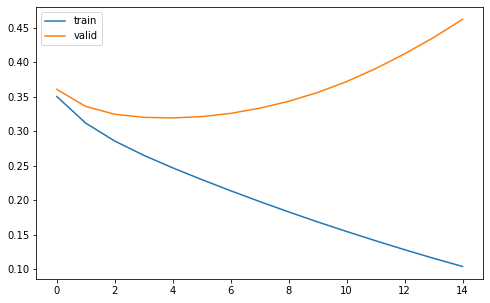

In [130]:
plt.figure(figsize=(8, 5))
plt.plot(all_tr_loss)
plt.plot(all_val_loss)
plt.legend(['train', 'valid'])
plt.show()

In [131]:
model_s = RnnModel(64)
model_s.load_state_dict(torch.load(FOLDER + 'rnn_valid.pt'))
model_s = model_s.to(device)

In [132]:
# def predict(x: str, mdl, trie, multimap: Dict):
#     x = x.copy().lower()
#     inp_var = []
#     for sw1 in TRIE.keys(x):
#         pass

# Check Accuracy

In [133]:
from sklearn.metrics import accuracy_score

res = {'train': None, 'val': None}
all_tar = {'train': None, 'val': None}

for mode in ['train', 'val']:
    model.eval()
    h0 =  model.init_hidden(batch_size)
    h0 = h0.to(device)
    for batch_idx, batch in enumerate(dataloaders[mode]):
        input = batch[0]
        input = tensorToGlove(input, glove).double().to(device)

        if batch_idx == 0:
            all_tar[mode] = batch[1].cpu()
        else:
            all_tar[mode] = torch.cat((all_tar[mode], batch[1].cpu()))
        
        with torch.set_grad_enabled(False):
            out, _ = model_s(input, h0)
            if batch_idx == 0:
                res[mode] = out.cpu()
            else:
                res[mode] = torch.cat((res[mode], out.cpu()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [134]:
print('train', (accuracy_score(all_tar['train'].numpy(), res['train'].numpy() > 0.5)))
print('valid', (accuracy_score(all_tar['val'].numpy(), res['val'].numpy() > 0.5)))

train 0.9040903141361256
valid 0.8807651991614256


check target rate

In [135]:
print(y_train_np.mean())
print(y_test_np.mean())

0.4779123036649215
0.4704881560005235
